# Revolut ML Engineer NLP Challenge

## Notebook for exploratory analysis of textual data

In [206]:
import string
import json
import re
from tqdm import tqdm

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# NLTK
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

import pickle

# postgre sql
import psycopg2

### Reading the datasets in pandas dataframes

In [2]:
companies_df = pd.read_csv("data/complaints_companies.csv")
users_df = pd.read_csv("data/complaints_users.csv")
products_df = pd.read_csv("data/products.csv")
issues_df = pd.read_csv("data/issues.csv")

/Users/mohammadtanweer/Documents/software/anaconda3/envs/revolut/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print (companies_df.shape)
companies_df.head()

(383066, 6)


,COMPLAINT_ID,COMPANY,COMPANY_RESPONSE_TO_USER,COMPANY_RESPONSE_TO_PUBLIC,WAS_RESPONSE_TIMELY,DATE
0,3184195,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",Closed with explanation,Company has responded to the consumer and the ...,Yes,03/19/2019
1,3184692,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",Closed with explanation,Company has responded to the consumer and the ...,Yes,03/19/2019
2,3183613,Experian Information Solutions Inc.,Closed with non-monetary relief,Company has responded to the consumer and the ...,Yes,03/18/2019
3,3182430,"McCarthy, Burgess & Wolff, Inc.",Closed with explanation,Company believes it acted appropriately as aut...,Yes,03/17/2019
4,3182218,"Patriot Finance, LLC",Closed with explanation,Company believes it acted appropriately as aut...,Yes,03/17/2019


In [4]:
print(users_df.shape)
users_df.head()

(383066, 6)


,COMPLAINT_ID,COMPLAINT_TEXT,WAS_USER_DISPUTED,DATE,PRODUCT_ID,ISSUE_ID
0,3184195,XXXX and Transunion are reporting incorrectly...,NaN,03/19/2019,26,253
1,3184692,XXXX and Transunion are reporting incorrectly ...,NaN,03/19/2019,26,253
2,3183613,"XXXX, XXXX, and Experian need to remove the co...",NaN,03/18/2019,26,165
3,3182430,"3 company with inconsistencies, violations and...",NaN,03/17/2019,26,253
4,3182218,I have a personal loan from Patriot finance. T...,NaN,03/17/2019,26,165


In [5]:
print(products_df.shape)
products_df.head()

(98, 3)


,PRODUCT_ID,MAIN_PRODUCT,SUB_PRODUCT
0,26,"Credit reporting, credit repair services, or o...",Credit reporting
1,37,Debt collection,Medical debt
2,39,Debt collection,Mortgage debt
3,90,Student loan,Federal student loan servicing
4,42,Debt collection,Other debt


In [6]:
print(issues_df.shape)
issues_df.head()

(353, 3)


,ISSUE_ID,MAIN_ISSUE,SUB_ISSUE
0,253,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...
1,165,Incorrect information on your report,Account status incorrect
2,18,Attempts to collect debt not owed,Debt was paid
3,349,Written notification about debt,Didn't receive enough information to verify debt
4,300,Struggling to repay your loan,Can't get other flexible options for repaying ...


## Task:
The task in hand is to use the text data (**"COMPLAINT_TEXT"** from **complaints_users**) to identify the products (main-product and sub-product) it is related to. 
The `complaint_users` table gives us the product_id and the corresponding main-product and sub-product can be obtained from `issues` table.
Let's join these two tables to create a single dataframe with required information.

In [7]:
users_df.isnull().any()

COMPLAINT_ID         False
COMPLAINT_TEXT       False
WAS_USER_DISPUTED     True
DATE                 False
PRODUCT_ID           False
ISSUE_ID             False
dtype: bool

In [8]:
# Let's check no of unique products
print(f'No of unique Product Ids      : {len(products_df.PRODUCT_ID.unique())}')
print(f'No of unique Main Products    : {len(products_df.MAIN_PRODUCT.unique())}')
print(f'No of unique Sub Products.    : {len(products_df.SUB_PRODUCT.unique())}')

No of unique Product Ids      : 98
No of unique Main Products    : 18
No of unique Sub Products.    : 76


In [9]:
products_df.isnull().any()

PRODUCT_ID      False
MAIN_PRODUCT    False
SUB_PRODUCT      True
dtype: bool

In [10]:
products_df[products_df.SUB_PRODUCT.isnull()].shape

(3, 3)

In [11]:
products_df[products_df.SUB_PRODUCT.isnull()]

,PRODUCT_ID,MAIN_PRODUCT,SUB_PRODUCT
51,23,Credit card,NaN
52,28,Credit reporting,NaN
71,80,Payday loan,NaN


#### 3 Main Products have undefined Sub Products. Let us check if these Main Products have other Sub Products associated with them

In [12]:
print(products_df[products_df.MAIN_PRODUCT == 'Payday loan'].shape)
products_df[products_df.MAIN_PRODUCT == 'Payday loan']

(1, 3)


,PRODUCT_ID,MAIN_PRODUCT,SUB_PRODUCT
71,80,Payday loan,NaN


In [13]:
print(products_df[products_df.MAIN_PRODUCT == 'Credit reporting'].shape)
products_df[products_df.MAIN_PRODUCT == 'Credit reporting']

(1, 3)


,PRODUCT_ID,MAIN_PRODUCT,SUB_PRODUCT
52,28,Credit reporting,NaN


In [14]:
print(products_df[products_df.MAIN_PRODUCT == 'Credit card'].shape)
products_df[products_df.MAIN_PRODUCT == 'Credit card']

(1, 3)


,PRODUCT_ID,MAIN_PRODUCT,SUB_PRODUCT
51,23,Credit card,NaN


Quick analysis shows that the three main-products **Payday loan, Credit reporting, Credit card** does not have any sub products. Let's update the sub-product with unique values to remove null values

In [15]:
products_df.loc[products_df.MAIN_PRODUCT == 'Payday loan', "SUB_PRODUCT"] = "Payday loan NaN"
products_df.loc[products_df.MAIN_PRODUCT == 'Credit reporting', "SUB_PRODUCT"] = "Credit reporting NaN"
products_df.loc[products_df.MAIN_PRODUCT == 'Credit card', "SUB_PRODUCT"] = "Credit card NaN"

In [16]:
print(products_df[products_df.MAIN_PRODUCT == 'Credit card'].shape)
products_df[products_df.MAIN_PRODUCT == 'Credit card']

(1, 3)


,PRODUCT_ID,MAIN_PRODUCT,SUB_PRODUCT
51,23,Credit card,Credit card NaN


### Let's join the users dataframe with the products dataframe to get one single dataframe

In [79]:
df = users_df.join(products_df.set_index('PRODUCT_ID'), on='PRODUCT_ID')

In [80]:
print(df.shape)
df.head()

(383066, 8)


,COMPLAINT_ID,COMPLAINT_TEXT,WAS_USER_DISPUTED,DATE,PRODUCT_ID,ISSUE_ID,MAIN_PRODUCT,SUB_PRODUCT
0,3184195,XXXX and Transunion are reporting incorrectly...,NaN,03/19/2019,26,253,"Credit reporting, credit repair services, or o...",Credit reporting
1,3184692,XXXX and Transunion are reporting incorrectly ...,NaN,03/19/2019,26,253,"Credit reporting, credit repair services, or o...",Credit reporting
2,3183613,"XXXX, XXXX, and Experian need to remove the co...",NaN,03/18/2019,26,165,"Credit reporting, credit repair services, or o...",Credit reporting
3,3182430,"3 company with inconsistencies, violations and...",NaN,03/17/2019,26,253,"Credit reporting, credit repair services, or o...",Credit reporting
4,3182218,I have a personal loan from Patriot finance. T...,NaN,03/17/2019,26,165,"Credit reporting, credit repair services, or o...",Credit reporting


In [81]:
df.isnull().any()

COMPLAINT_ID         False
COMPLAINT_TEXT       False
WAS_USER_DISPUTED     True
DATE                 False
PRODUCT_ID           False
ISSUE_ID             False
MAIN_PRODUCT         False
SUB_PRODUCT          False
dtype: bool

In [82]:
# Select required columns only
cols = ['COMPLAINT_ID', 'COMPLAINT_TEXT', 'PRODUCT_ID', 'MAIN_PRODUCT', 'SUB_PRODUCT']
df = df[cols]

In [83]:
df.set_index('COMPLAINT_ID', inplace=True)

In [84]:
df.groupby(['PRODUCT_ID', 'MAIN_PRODUCT', 'SUB_PRODUCT']).size()

PRODUCT_ID  MAIN_PRODUCT                                                                  SUB_PRODUCT                               
0           Bank account or service                                                       (CD) Certificate of deposit                     274
1           Bank account or service                                                       Cashing a check without an account              134
2           Bank account or service                                                       Checking account                              10113
3           Bank account or service                                                       Other bank product/service                     3477
4           Bank account or service                                                       Savings account                                 887
5           Checking or savings account                                                   CD (Certificate of Deposit)                     229
6           Che

In [85]:
df.groupby(['SUB_PRODUCT', 'MAIN_PRODUCT', 'PRODUCT_ID']).count()

COMPLAINT_TEXT
SUB_PRODUCT                                MAIN_PRODUCT                                       PRODUCT_ID                
(CD) Certificate of deposit                Bank account or service                            0                      274
Auto                                       Debt collection                                    29                    1064
Auto debt                                  Debt collection                                    30                    1660
CD (Certificate of Deposit)                Checking or savings account                        5                      229
Cashing a check without an account         Bank account or service                            1                      134
Check cashing                              Other financial service                            68                      54
Check cashing service                      Money transfer, virtual currency, or money service 46                      89
Checking account                           Bank account or service                            2                    10113
                                           Checking or savings account                        6                    10709
Conventional adjustable mortgage (ARM)     Mortgage                                           58                    4975
Conventional fixed mortgage                Mortgage                                           59                   14562
Conventional home mortgage                 Credit reporting, credit repair services, or ot... 24                       1
                                           Mortgage                                           60                   12098
Credit card                                Debt collection                                    31                    7520
Credit card NaN                            Credit card                                        23                   18838
Credit card debt                           Debt collection                                    32                   10021
Credit repair                              Other financial service                            69                      39
Credit repair services                     Credit reporting, credit repair services, or ot... 25                     457
Credit reporting                           Credit reporting, credit repair services, or ot... 26                   89994
Credit reporting NaN                       Credit reporting                                   28                   31588
Debt settlement                            Money transfer, virtual currency, or money service 47                      56
                                           Other financial service                            70                     109
Domestic (US) money transfer               Money transfer, virtual currency, or money service 48                    1636
                                           Money transfers                                    56                     861
                                           Virtual currency                                   96                      15
Electronic Benefit Transfer / EBT card     Prepaid card                                       81                       3
FHA mortgage                               Mortgage                                           61                    9788
Federal student loan                       Debt collection                                    33                     549
Federal student loan debt                  Debt collection                                    34                     795
Federal student loan servicing             Student loan                                       90                   12138
Foreign currency exchange                  Money transfer, virtual currency, or money service 49                      67
                                           Other financial service                            71                 

The task in hand is to use user's complain text to predict the Main Product and Sub Product which means to predict the product id. Let's analyze the distribution of Product Ids in the dataset

In [86]:
df.PRODUCT_ID.value_counts()

26    89994
28    31588
23    18838
35    16887
16    16243
59    14562
42    13385
41    12393
90    12138
60    12098
6     10709
2     10113
32    10021
61     9788
37     7893
31     7520
36     6990
91     5753
15     5141
58     4975
94     4719
92     3888
21     3838
3      3477
64     3236
10     3094
67     2834
62     2103
43     2064
44     1824
27     1763
80     1747
75     1739
30     1660
48     1636
65     1512
77     1427
55     1388
63     1228
51     1199
39     1112
29     1064
7      1041
93     1007
14      962
38      907
4       887
17      877
9       867
56      861
45      802
34      795
50      791
78      752
82      730
40      684
57      636
66      599
33      549
79      475
25      457
0       274
5       229
88      220
13      199
19      189
83      154
1       134
70      109
18      103
85      101
54       96
52       92
20       91
46       89
86       85
84       80
49       67
87       58
47       56
68       54
53       49
12       44
69  

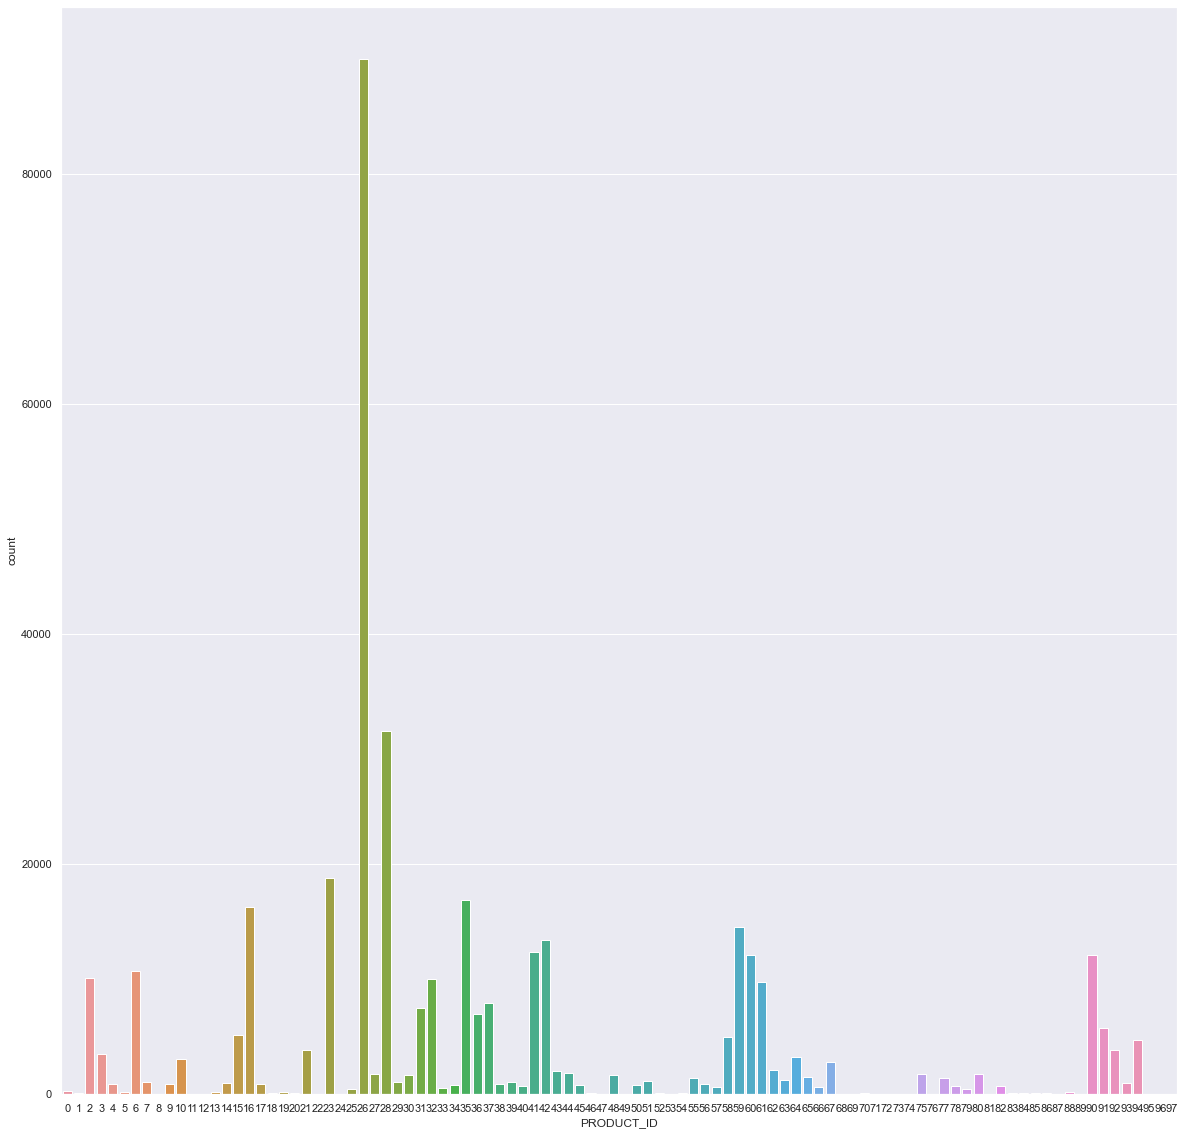

In [87]:
plt.figure(figsize=(20,20))
sns.set(style="darkgrid")
ax = sns.countplot(x="PRODUCT_ID", data=df)

## Data Imbalance
We can see that number of complains for many of the Product Ids are very less. We might not enough data for these products or these are very stable products and did not get much complains about them

In order to build a model to predict the Product Ids, we need to drop some of the less occuring products from the corpus.

Let us analyze further to see what all products we can drop.

In [88]:
# Creating a dataframe with record counts for each product-id
count_df = pd.DataFrame({'COUNT': df.groupby(['PRODUCT_ID', 'MAIN_PRODUCT', 'SUB_PRODUCT']).size()}).reset_index()

In [89]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
count_df.head(100)

,PRODUCT_ID,MAIN_PRODUCT,SUB_PRODUCT,COUNT
0,0,Bank account or service,(CD) Certificate of deposit,274
1,1,Bank account or service,Cashing a check without an account,134
2,2,Bank account or service,Checking account,10113
3,3,Bank account or service,Other bank product/service,3477
4,4,Bank account or service,Savings account,887
5,5,Checking or savings account,CD (Certificate of Deposit),229
6,6,Checking or savings account,Checking account,10709
7,7,Checking or savings account,Other banking product or service,1041
8,8,Checking or savings account,Personal line of credit,12
9,9,Checking or savings account,Savings account,867


### Product Ids with less than 500 record counts:

In [90]:
print(f'No. of Product Ids with less than 500 records: {count_df[count_df.COUNT < 500].shape[0]}')
count_df[count_df.COUNT < 500].head(100)

No. of Product Ids with less than 500 records: 39


,PRODUCT_ID,MAIN_PRODUCT,SUB_PRODUCT,COUNT
0,0,Bank account or service,(CD) Certificate of deposit,274
1,1,Bank account or service,Cashing a check without an account,134
5,5,Checking or savings account,CD (Certificate of Deposit),229
8,8,Checking or savings account,Personal line of credit,12
11,11,Consumer Loan,Pawn loan,34
12,12,Consumer Loan,Personal line of credit,44
13,13,Consumer Loan,Title loan,199
18,18,Credit card or prepaid card,Gift card,103
19,19,Credit card or prepaid card,Government benefit card,189
20,20,Credit card or prepaid card,Payroll card,91


In [91]:
prd_ids = list(count_df[count_df.COUNT < 500].PRODUCT_ID.values)

In [92]:
df = df[~df.PRODUCT_ID.isin(prd_ids)]

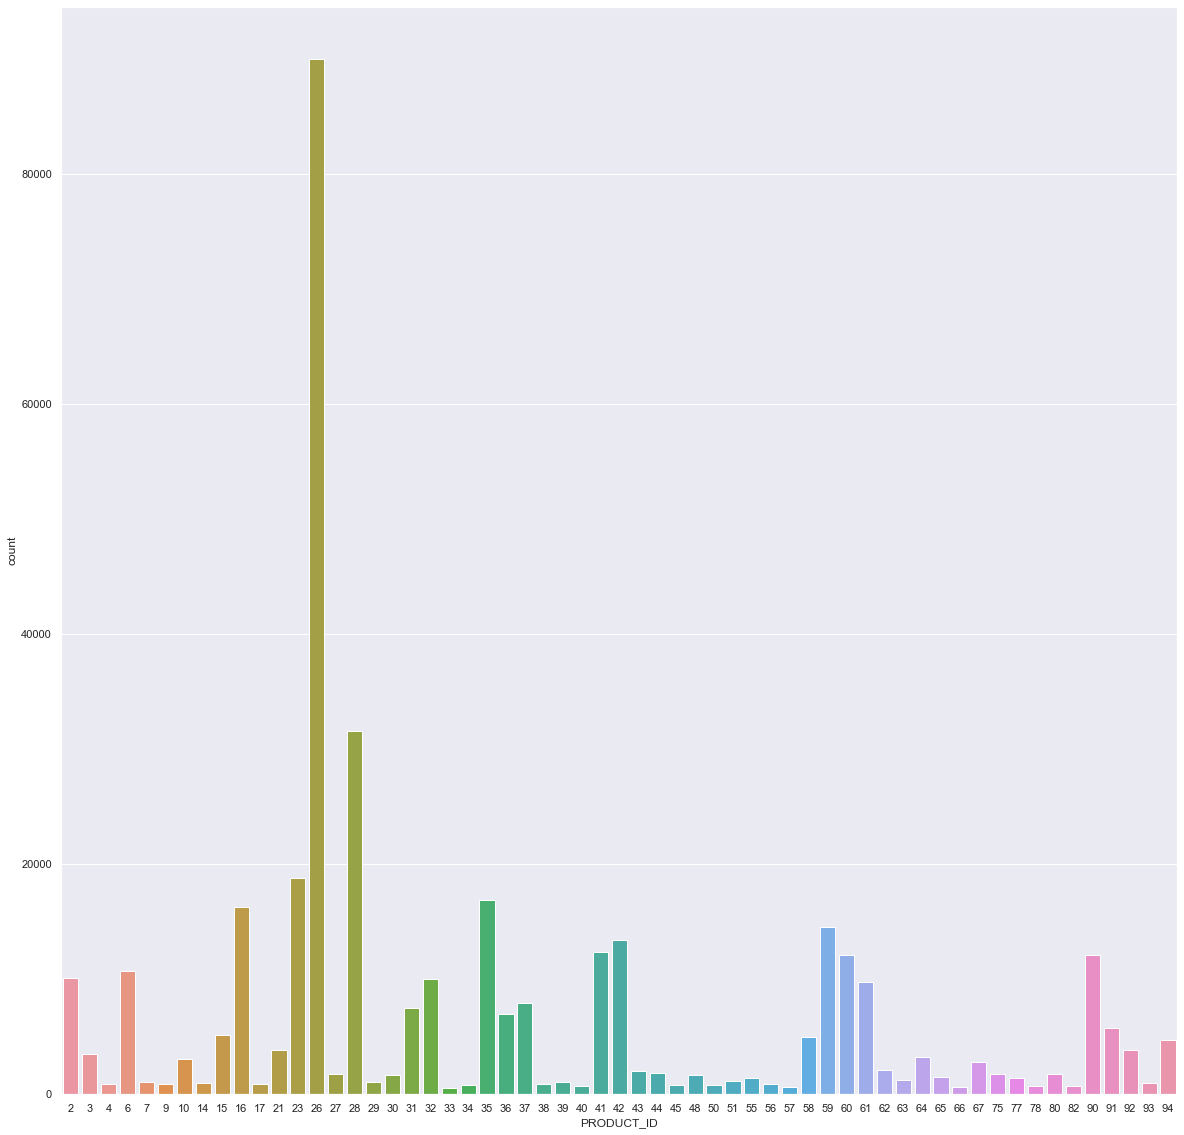

In [93]:
plt.figure(figsize=(20,20))
sns.set(style="darkgrid")
ax = sns.countplot(x="PRODUCT_ID", data=df)

## Data Imbalance is still there
We still have data imbalance but we can try building a model to predict for these Product Ids. But before builing the model, let's do textual data analysis

# Textual data analysis

In [94]:
from tqdm import tqdm

import string
import json
import re

# NLTK
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [95]:
tqdm.pandas()

/Users/mohammadtanweer/Documents/software/anaconda3/envs/revolut/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [96]:
PUNCTUATION = set(string.punctuation)
STOPWORDS = list(stopwords.words('english'))
STEMMER = PorterStemmer()
LEMMATIZER = WordNetLemmatizer()

In [97]:
def tokenize(text):    
    tokens = word_tokenize(text)
    # print (tokens)
    lowercased = [t.lower() for t in tokens]
    no_punctuation = []
    for word in lowercased:
        punct_removed = ''.join([letter for letter in word if not letter in PUNCTUATION])
        no_punctuation.append(punct_removed)
    no_stopwords = [w.strip() for w in no_punctuation if not w in STOPWORDS]
    lemmatized = [LEMMATIZER.lemmatize(w) for w in no_stopwords]
    return [w for w in lemmatized if len(w) > 2]

In [98]:
df['TOKENS'] = df['COMPLAINT_TEXT'].progress_map(tokenize)

100%|██████████| 379328/379328 [13:08<00:00, 480.78it/s]  


In [99]:
df.head()

,COMPLAINT_TEXT,PRODUCT_ID,MAIN_PRODUCT,SUB_PRODUCT,TOKENS
COMPLAINT_ID,,,,,
3184195,XXXX and Transunion are reporting incorrectly...,26,"Credit reporting, credit repair services, or o...",Credit reporting,"[xxxx, transunion, reporting, incorrectly, 120..."
3184692,XXXX and Transunion are reporting incorrectly ...,26,"Credit reporting, credit repair services, or o...",Credit reporting,"[xxxx, transunion, reporting, incorrectly, 120..."
3183613,"XXXX, XXXX, and Experian need to remove the co...",26,"Credit reporting, credit repair services, or o...",Credit reporting,"[xxxx, xxxx, experian, need, remove, collectio..."
3182430,"3 company with inconsistencies, violations and...",26,"Credit reporting, credit repair services, or o...",Credit reporting,"[company, inconsistency, violation, double, je..."
3182218,I have a personal loan from Patriot finance. T...,26,"Credit reporting, credit repair services, or o...",Credit reporting,"[personal, loan, patriot, finance, incorrectly..."


In [101]:
def to_lower(text):
    return text.lower()
df.COMPLAINT_TEXT = df.COMPLAINT_TEXT.progress_map(to_lower)

100%|██████████| 379328/379328 [00:01<00:00, 339208.76it/s]


In [102]:
df.head()

,COMPLAINT_TEXT,PRODUCT_ID,MAIN_PRODUCT,SUB_PRODUCT,TOKENS
COMPLAINT_ID,,,,,
3184195,xxxx and transunion are reporting incorrectly...,26,"Credit reporting, credit repair services, or o...",Credit reporting,"[xxxx, transunion, reporting, incorrectly, 120..."
3184692,xxxx and transunion are reporting incorrectly ...,26,"Credit reporting, credit repair services, or o...",Credit reporting,"[xxxx, transunion, reporting, incorrectly, 120..."
3183613,"xxxx, xxxx, and experian need to remove the co...",26,"Credit reporting, credit repair services, or o...",Credit reporting,"[xxxx, xxxx, experian, need, remove, collectio..."
3182430,"3 company with inconsistencies, violations and...",26,"Credit reporting, credit repair services, or o...",Credit reporting,"[company, inconsistency, violation, double, je..."
3182218,i have a personal loan from patriot finance. t...,26,"Credit reporting, credit repair services, or o...",Credit reporting,"[personal, loan, patriot, finance, incorrectly..."


In [103]:
def get_bigrams(tokens):
    return list(nltk.bigrams(tokens))

def get_trigrams(tokens):
    return list(nltk.trigrams(tokens))

In [104]:
df['BI_GRAMS'] = df['TOKENS'].progress_map(get_bigrams)

100%|██████████| 379328/379328 [00:18<00:00, 20164.80it/s]


In [105]:
df['TRI_GRAMS'] = df['TOKENS'].progress_map(get_trigrams)

100%|██████████| 379328/379328 [01:42<00:00, 3704.12it/s] 


In [106]:
df.head()

,COMPLAINT_TEXT,PRODUCT_ID,MAIN_PRODUCT,SUB_PRODUCT,TOKENS,BI_GRAMS,TRI_GRAMS
COMPLAINT_ID,,,,,,,
3184195,xxxx and transunion are reporting incorrectly...,26,"Credit reporting, credit repair services, or o...",Credit reporting,"[xxxx, transunion, reporting, incorrectly, 120...","[(xxxx, transunion), (transunion, reporting), ...","[(xxxx, transunion, reporting), (transunion, r..."
3184692,xxxx and transunion are reporting incorrectly ...,26,"Credit reporting, credit repair services, or o...",Credit reporting,"[xxxx, transunion, reporting, incorrectly, 120...","[(xxxx, transunion), (transunion, reporting), ...","[(xxxx, transunion, reporting), (transunion, r..."
3183613,"xxxx, xxxx, and experian need to remove the co...",26,"Credit reporting, credit repair services, or o...",Credit reporting,"[xxxx, xxxx, experian, need, remove, collectio...","[(xxxx, xxxx), (xxxx, experian), (experian, ne...","[(xxxx, xxxx, experian), (xxxx, experian, need..."
3182430,"3 company with inconsistencies, violations and...",26,"Credit reporting, credit repair services, or o...",Credit reporting,"[company, inconsistency, violation, double, je...","[(company, inconsistency), (inconsistency, vio...","[(company, inconsistency, violation), (inconsi..."
3182218,i have a personal loan from patriot finance. t...,26,"Credit reporting, credit repair services, or o...",Credit reporting,"[personal, loan, patriot, finance, incorrectly...","[(personal, loan), (loan, patriot), (patriot, ...","[(personal, loan, patriot), (loan, patriot, fi..."


In [107]:
bigrams_list = [x for x in df.iloc[:,5]]
bigrams_list = [item for sublist in bigrams_list for item in sublist]

In [108]:
bigrams_list[:10]

[('xxxx', 'transunion'),
 ('transunion', 'reporting'),
 ('reporting', 'incorrectly'),
 ('incorrectly', '120'),
 ('120', 'day'),
 ('day', 'past'),
 ('past', 'due'),
 ('due', 'loan'),
 ('loan', 'xxxx'),
 ('xxxx', 'partial')]

In [109]:
trigrams_list = [x for x in df.iloc[:,6]]
trigrams_list = [item for sublist in trigrams_list for item in sublist]

In [110]:
trigrams_list[:10]

[('xxxx', 'transunion', 'reporting'),
 ('transunion', 'reporting', 'incorrectly'),
 ('reporting', 'incorrectly', '120'),
 ('incorrectly', '120', 'day'),
 ('120', 'day', 'past'),
 ('day', 'past', 'due'),
 ('past', 'due', 'loan'),
 ('due', 'loan', 'xxxx'),
 ('loan', 'xxxx', 'partial'),
 ('xxxx', 'partial', 'account')]

In [111]:
from collections import Counter

In [112]:
bigrams_freq = Counter(bigrams_list)
bigrams_freq.most_common(10)

[(('xxxx', 'xxxx'), 1662740),
 (('credit', 'report'), 166768),
 (('credit', 'card'), 77787),
 (('xxxxxxxx', 'xxxx'), 59074),
 (('xxxx', 'xxxxxxxx'), 57065),
 (('credit', 'bureau'), 55232),
 (('well', 'fargo'), 43509),
 (('account', 'xxxx'), 40967),
 (('xxxxxxxx', 'xxxxxxxx'), 40450),
 (('xxxx', 'account'), 38230)]

In [113]:
trigrams_freq = Counter(trigrams_list)
trigrams_freq.most_common(10)

[(('xxxx', 'xxxx', 'xxxx'), 897745),
 (('xxxxxxxx', 'xxxx', 'xxxx'), 35049),
 (('xxxx', 'xxxx', 'xxxxxxxx'), 33110),
 (('xxxx', 'xxxxxxxx', 'xxxx'), 24965),
 (('xxxx', 'xxxx', 'account'), 18869),
 (('account', 'xxxx', 'xxxx'), 18627),
 (('credit', 'reporting', 'agency'), 16326),
 (('name', 'xxxx', 'xxxx'), 12838),
 (('xxxxxxxx', 'xxxxxxxx', 'xxxxxxxx'), 12515),
 (('fair', 'credit', 'reporting'), 12132)]

In [114]:
unigrams_list = list(df.TOKENS)
unigrams_list = [item for sublist in unigrams_list for item in sublist]

In [115]:
unigrams_freq = Counter(unigrams_list)
unigrams_freq.most_common(10)

[('xxxx', 3366482),
 ('credit', 583836),
 ('account', 577690),
 ('xxxxxxxx', 400203),
 ('payment', 398794),
 ('loan', 307121),
 ('report', 285999),
 ('would', 260464),
 ('information', 231682),
 ('time', 229660)]

In [116]:
unigrams_freq = {str(k): v for k, v in unigrams_freq.items()}

In [117]:
unigrams_freq

{'xxxx': 3366482,
 'transunion': 29693,
 'reporting': 121382,
 'incorrectly': 6340,
 '120': 3482,
 'day': 163312,
 'past': 42077,
 'due': 114010,
 'loan': 307121,
 'partial': 3230,
 'account': 577690,
 'number': 126173,
 'reflect': 5913,
 '000': 8636,
 'balance': 106054,
 'contacted': 75040,
 'two': 45299,
 'bureau': 78749,
 'requested': 58350,
 'coding': 202,
 'error': 34573,
 'corrected': 10770,
 'incorrect': 23427,
 'harming': 457,
 'credit': 583836,
 'score': 46125,
 'impossible': 5526,
 'numberxxxx': 180,
 'reflects': 1783,
 'experian': 38713,
 'need': 70542,
 'remove': 49770,
 'collection': 118689,
 'submitted': 32462,
 'dispute': 86307,
 'file': 77091,
 'debt': 215492,
 'valid': 11455,
 'original': 50850,
 'creditor': 45458,
 'provide': 58523,
 'fully': 5910,
 'executed': 1426,
 'contract': 35673,
 'refuse': 22436,
 'proof': 51342,
 'cancelled': 10186,
 'business': 51818,
 'would': 260464,
 'settled': 6668,
 'factfinding': 9,
 'process': 46436,
 'civil': 4902,
 'court': 40155,
 

In [118]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

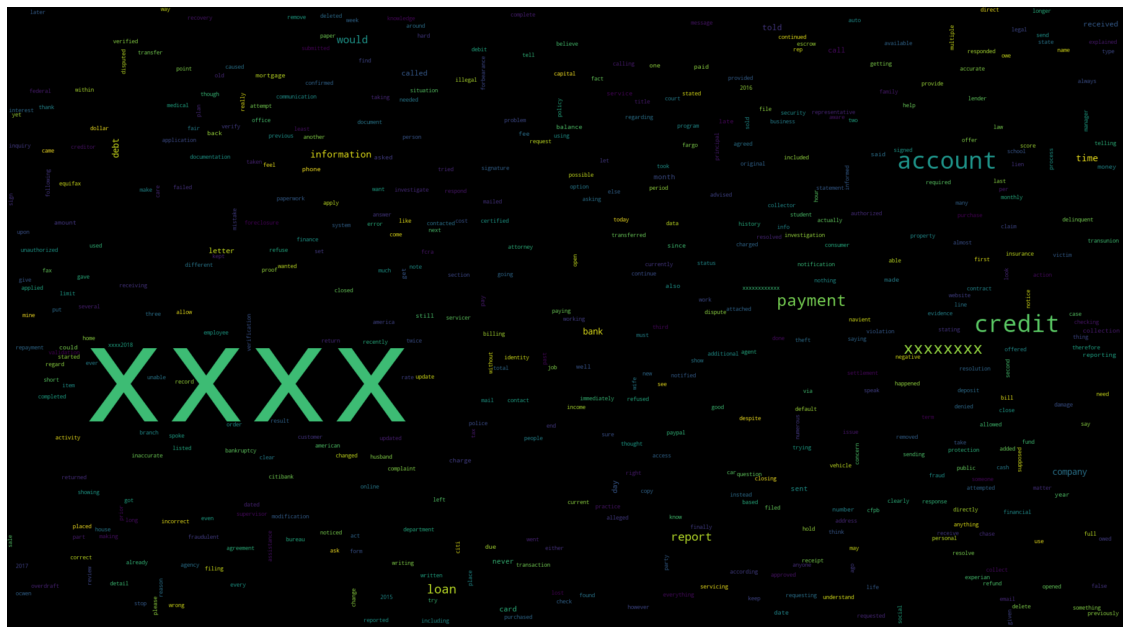

In [119]:
plt.figure(figsize=(20,20))
wordcloud = WordCloud(width=1800,height=1000, background_color="black", 
                      max_words=500,relative_scaling=1, 
                      normalize_plurals=False).generate_from_frequencies(unigrams_freq)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## `xxxx` frequency is very high compare to other words. Let's get rid of this masking characters

In [190]:
def clean_text(text):
    text = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|(\d+)"," ",text)
    text = re.sub("xxxx+", "", text)
    return text

In [191]:
df.COMPLAINT_TEXT = df.COMPLAINT_TEXT.progress_map(clean_text)

100%|██████████| 379328/379328 [00:49<00:00, 7690.62it/s] 


In [192]:
df['TOKENS'] = df['COMPLAINT_TEXT'].progress_map(tokenize)

100%|██████████| 379328/379328 [08:40<00:00, 728.88it/s]  


In [193]:
unigrams_list = list(df.TOKENS)
unigrams_list = [item for sublist in unigrams_list for item in sublist]

In [194]:
unigrams_freq = Counter(unigrams_list)
unigrams_freq.most_common(10)

[('credit', 585899),
 ('account', 580436),
 ('payment', 402247),
 ('loan', 308763),
 ('report', 287410),
 ('time', 233911),
 ('information', 232401),
 ('debt', 217055),
 ('bank', 210886),
 ('company', 205255)]

In [195]:
unigrams_freq = {str(k): v for k, v in unigrams_freq.items()}

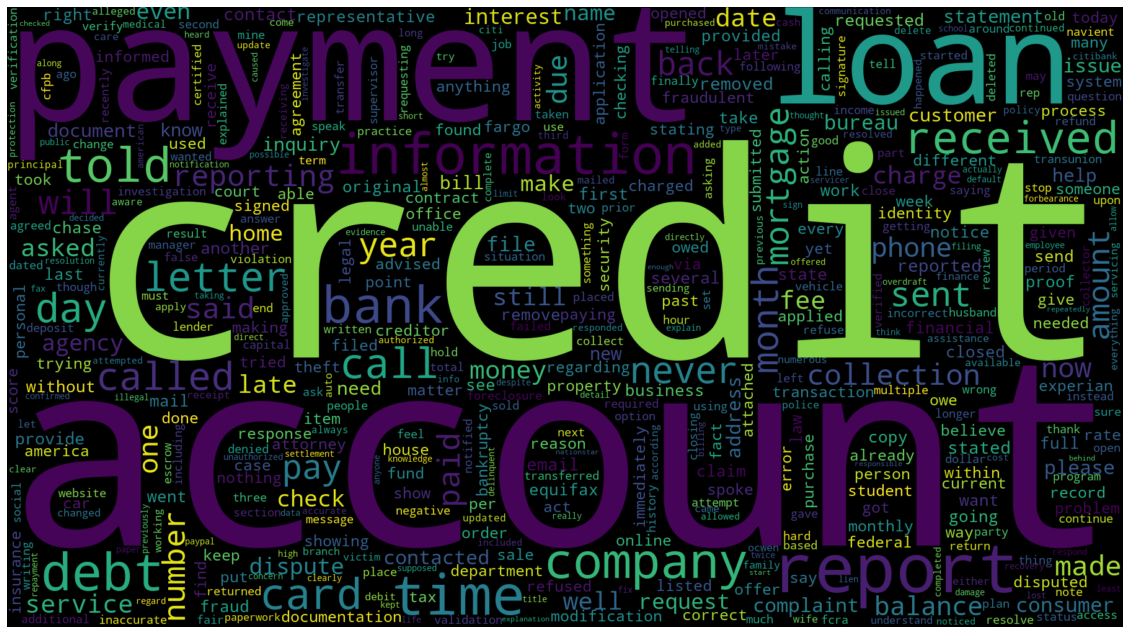

In [196]:
plt.figure(figsize=(20,20))
wordcloud = WordCloud(width=1800,height=1000, background_color="black", 
                      max_words=500,relative_scaling=1, 
                      normalize_plurals=False).generate_from_frequencies(unigrams_freq)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Let's generate the bi-grams and tri-grams again

In [197]:
df['BI_GRAMS'] = df['TOKENS'].progress_map(get_bigrams)
df['TRI_GRAMS'] = df['TOKENS'].progress_map(get_trigrams)

100%|██████████| 379328/379328 [00:30<00:00, 12428.04it/s]


In [198]:
bigrams_list = [x for x in df.iloc[:,5]]
bigrams_list = [item for sublist in bigrams_list for item in sublist]

trigrams_list = [x for x in df.iloc[:,6]]
trigrams_list = [item for sublist in trigrams_list for item in sublist]

In [199]:
bigrams_freq = Counter(bigrams_list)
bigrams_freq.most_common(10)

[(('credit', 'report'), 167694),
 (('credit', 'card'), 78565),
 (('credit', 'bureau'), 55494),
 (('well', 'fargo'), 43949),
 (('credit', 'reporting'), 38323),
 (('customer', 'service'), 32710),
 (('credit', 'score'), 30622),
 (('collection', 'agency'), 29409),
 (('bank', 'america'), 29320),
 (('phone', 'call'), 27185)]

In [200]:
trigrams_freq = Counter(trigrams_list)
trigrams_freq.most_common(10)

[(('credit', 'reporting', 'agency'), 16469),
 (('fair', 'credit', 'reporting'), 12140),
 (('credit', 'reporting', 'act'), 11993),
 (('social', 'security', 'number'), 10312),
 (('removed', 'credit', 'report'), 9137),
 (('account', 'credit', 'report'), 8001),
 (('consumer', 'reporting', 'agency'), 7624),
 (('victim', 'identity', 'theft'), 7415),
 (('debt', 'collection', 'practice'), 7239),
 (('information', 'credit', 'report'), 7137)]

In [201]:
bigrams_freq  = {'_'.join(k): v for k, v in bigrams_freq.items()}

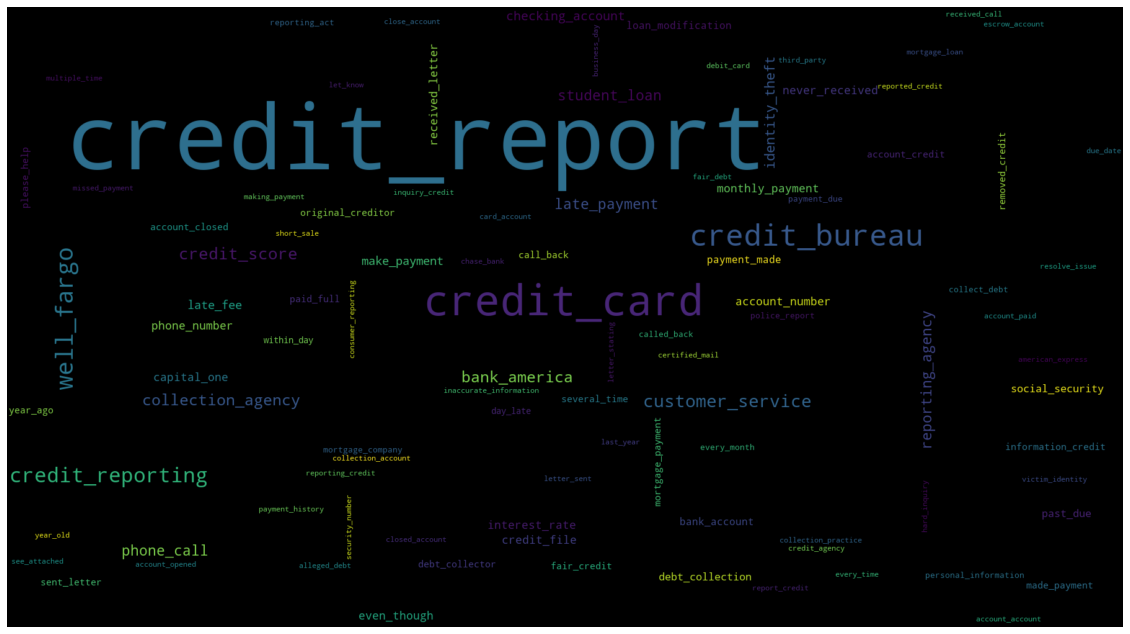

In [205]:
plt.figure(figsize=(20,20))
wordcloud = WordCloud(width=1800,height=1000, background_color="black", 
                      max_words=100,relative_scaling=1, 
                      normalize_plurals=False).generate_from_frequencies(bigrams_freq)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [203]:
trigrams_freq  = {'_'.join(k): v for k, v in trigrams_freq.items()}

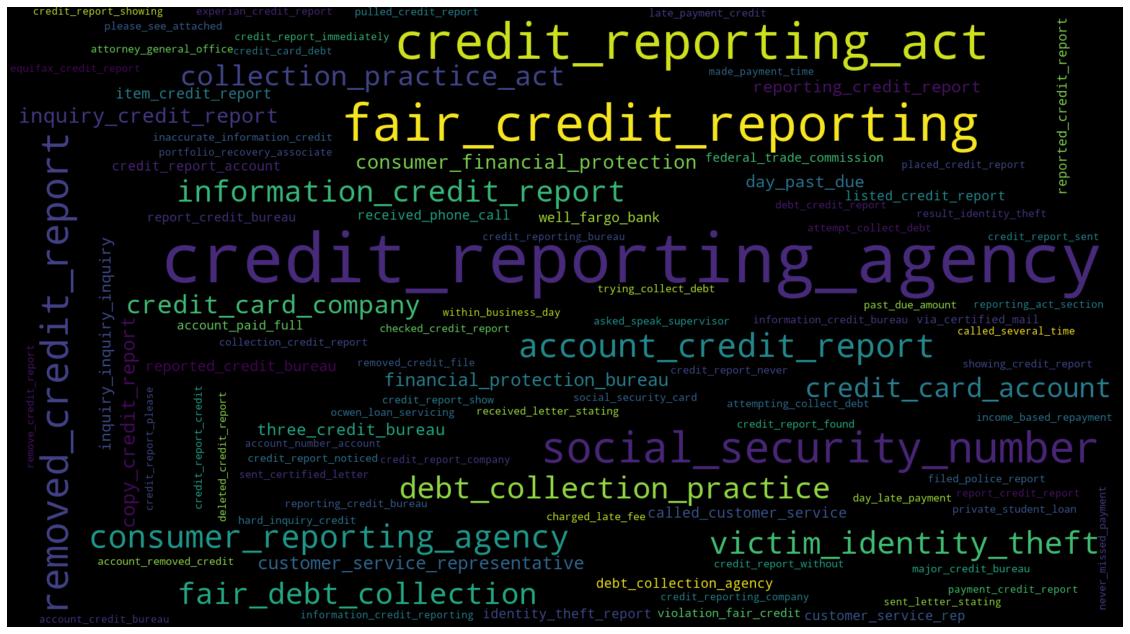

In [204]:
plt.figure(figsize=(20,20))
wordcloud = WordCloud(width=1800,height=1000, background_color="black", 
                      max_words=100,relative_scaling=1, 
                      normalize_plurals=False).generate_from_frequencies(trigrams_freq)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Summary:
* The data looks clean now with no or very less junk characters
* We can use this data to build and train our model
* We also need to ignore 39 Product Ids while building the models though we will explore the options in model building exercise